In [1]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


**Library**

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import seaborn as sns

import os
import zipfile
import shutil
from glob import glob

from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Activation, Flatten, MaxPool2D

**Data Gathering and Prepocessing**

In [3]:
# remove dataset (if already run the clone code only) in a new run
# ignore if no CycleMe folder in Colab Files
# !rm -rf '/content/CycleMe'

try:
    !rm -rf '/content/CycleMe'
    print("% s removed successfully")
except OSError as error:
    print(error)
    print("File is empty, can not be removed!")

% s removed successfully


In [4]:
!git clone https://github.com/notRobot200/CycleMe.git

Cloning into 'CycleMe'...
remote: Enumerating objects: 6601, done.
remote: Counting objects: 100% (860/860), done.
remote: Compressing objects: 100% (844/844), done.
remote: Total 6601 (delta 21), reused 851 (delta 16), pack-reused 5741
Receiving objects: 100% (6601/6601), 235.53 MiB | 18.99 MiB/s, done.
Resolving deltas: 100% (68/68), done.
Updating files: 100% (4287/4287), done.


In [5]:
# investigating unsupported image file
from pathlib import Path
import imghdr

DIR = '/content/CycleMe/CycleMeDataset'
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(DIR).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

/content/CycleMe/CycleMeDataset/Plastic/plast (12).jpg is not an image
/content/CycleMe/CycleMeDataset/Aluminium/alum (290).jpg is not an image
/content/CycleMe/CycleMeDataset/Aluminium/alum (271).jpg is not an image
/content/CycleMe/CycleMeDataset/Carton/cart (15).jpg is not an image
/content/CycleMe/CycleMeDataset/Glass/glass (336).jpg is not an image
/content/CycleMe/CycleMeDataset/Glass/glass (356).jpg is not an image
/content/CycleMe/CycleMeDataset/Glass/glass (11).jpg is not an image
/content/CycleMe/CycleMeDataset/Glass/glass (14).jpg is not an image
/content/CycleMe/CycleMeDataset/Glass/glass (7).jpg is not an image
/content/CycleMe/CycleMeDataset/Glass/glass (13).jpg is not an image
/content/CycleMe/CycleMeDataset/Glass/glass (10).jpg is not an image
/content/CycleMe/CycleMeDataset/Styrofoam/STYROFOAM (7).jpg is a webp, not accepted by TensorFlow
/content/CycleMe/CycleMeDataset/Styrofoam/STYROFOAM (3).jpg is a webp, not accepted by TensorFlow
/content/CycleMe/CycleMeDataset/St

In [6]:
# delete unsupported image file
img_link=list(Path(DIR).glob(r'**/*.jpg'))

count_num=0
for lnk in img_link:
    binary_img=open(lnk,'rb')
    find_img=tf.compat.as_bytes('JFIF') in binary_img.peek(10)#The JFIF is a JPEG File Interchange Format (JFIF). It is a standard which we gauge if an image is corrupt or substandard
    if not find_img:
        count_num+=1
        os.remove(str(lnk))
print('Total %d pcs image delete from Dataset' % count_num)
#this should help you delete the bad encoded

Total 79 pcs image delete from Dataset


In [7]:
#LOAD DATA
DIR = "/content/CycleMe/CycleMeDataset"
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1, subset="training", seed=42, batch_size=128, smart_resize=True, image_size=(256, 256))
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1, subset="validation", seed=42, batch_size=128, smart_resize=True, image_size=(256, 256))

classes = train_dataset.class_names
numClasses = len(train_dataset.class_names)
print(classes)

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 4201 files belonging to 8 classes.
Using 3781 files for training.
Found 4201 files belonging to 8 classes.
Using 420 files for validation.
['Aluminium', 'Carton', 'Glass', 'Organic Waste', 'Paper and Cardboard', 'Plastic', 'Styrofoam', 'Textiles']


In [8]:
# check data
aluminium_dir = os.path.join(DIR,'Aluminium')
carton_dir = os.path.join(DIR,'Carton')
glass_dir = os.path.join(DIR, 'Glass')
organic_dir = os.path.join(DIR, 'Organic Waste')
plastic_dir = os.path.join(DIR, 'Plastic')
paper_dir = os.path.join(DIR,'Paper and Cardboard')
styrofoam_dir = os.path.join(DIR, 'Styrofoam')
textiles_dir = os.path.join(DIR, 'Textiles')

print("Aluminium :", len(os.listdir(aluminium_dir)))
print("Carton:", len(os.listdir(carton_dir))) 
print("Glass :", len(os.listdir(glass_dir)))
print("Organic :", len(os.listdir(organic_dir)))
print("Plastic :", len(os.listdir(plastic_dir))) 
print("Paper :", len(os.listdir(paper_dir)))
print("Styrofoam :", len(os.listdir(styrofoam_dir)))
print("Textiles :", len(os.listdir(textiles_dir)))

Aluminium : 598
Carton: 323
Glass : 585
Organic : 542
Plastic : 593
Paper : 601
Styrofoam : 385
Textiles : 574


**Model Training**

In [9]:
baseModel = tf.keras.applications.MobileNetV3Small(input_shape=(256, 256,3), 
                                                   weights='imagenet', include_top=False, 
                                                   classes=numClasses)
for layers in baseModel.layers[:-6]:
  layers.trainable=False

last_output = baseModel.layers[-1].output
x = tf.keras.layers.Dropout(0.45) (last_output)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization() (x)
x = tf.keras.layers.Dense(192, activation = tf.keras.activations.elu, 
                          kernel_regularizer=tf.keras.regularizers.l1(0.045))(x)
x = tf.keras.layers.Dropout(0.45) (x)
x = tf.keras.layers.Dense(numClasses, activation='softmax')(x)

model = tf.keras.Model(inputs=baseModel.input,outputs=x)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00125), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

epochs = 30
lrCallback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10 ** (epoch / 30))
stepDecay = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.1 * 0.1**math.floor(epoch / 6))
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs, callbacks=[])

4334752/4334752 [==============================] - 0s 0us/step
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


30/30 [==============================] - 106s 3s/step - loss: 147.0991 - accuracy: 0.4792 - val_loss: 78.5790 - val_accuracy: 0.6905
Epoch 2/30
30/30 [==============================] - 99s 3s/step - loss: 40.2659 - accuracy: 0.7368 - val_loss: 11.8033 - val_accuracy: 0.7714
Epoch 3/30
30/30 [==============================] - 97s 3s/step - loss: 6.1281 - accuracy: 0.7374 - val_loss: 3.7104 - val_accuracy: 0.6357
Epoch 4/30
30/30 [==============================] - 101s 3s/step - loss: 3.1457 - accuracy: 0.6517 - val_loss: 2.9111 - val_accuracy: 0.6452
Epoch 5/30
30/30 [==============================] - 95s 3s/step - loss: 2.8004 - accuracy: 0.6567 - val_loss: 2.7348 - val_accuracy: 0.6476
Epoch 6/30
30/30 [==============================] - 98s 3s/step - loss: 2.6981 - accuracy: 0.6705 - val_loss: 2.5973 - val_accuracy: 0.6833
Epoch 7/30
30/30 [==============================] - 97s 3s/step - loss: 2.5890 - accuracy: 0.6903 - val_loss: 2.4599 - val_accuracy: 0.7595
Epoch 8/30
30/30 [======

In [10]:
model.save("/content/model.h5")
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 128, 128, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

**Model Evaluation**

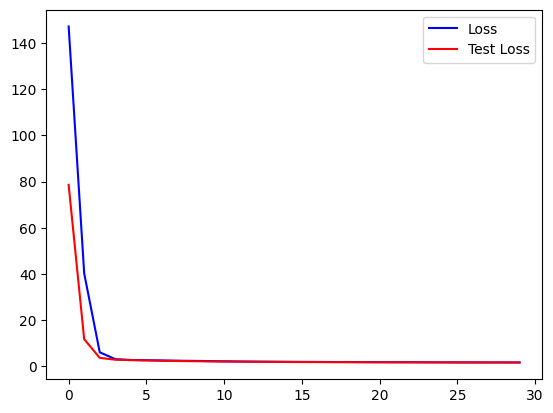

In [11]:
plt.plot(range(0, epochs), history.history["loss"], color="b", label="Loss")
plt.plot(range(0, epochs), history.history["val_loss"], color="r", label="Test Loss")
plt.legend()
plt.show()

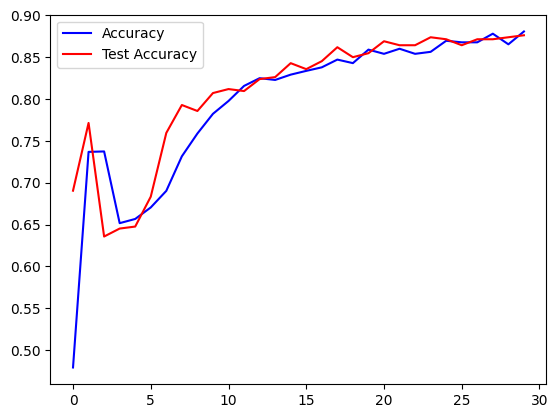

In [12]:
plt.plot(range(0, epochs), history.history["accuracy"], color="b", label="Accuracy")
plt.plot(range(0, epochs), history.history["val_accuracy"], color="r", label="Test Accuracy")
plt.legend()
plt.show()

Text(0, 0.5, 'Loss')

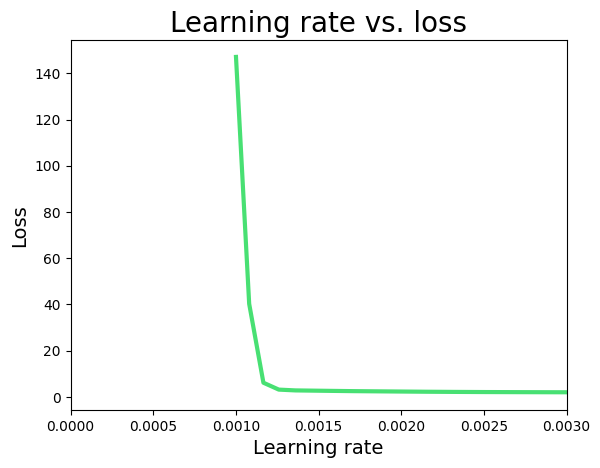

In [13]:
plt.xlim([0, 0.003])
learning_rates = 1e-3 * (10 ** (np.arange(epochs) / 30))
plt.plot(learning_rates, history.history['loss'], lw=3, color='#48e073')
plt.title('Learning rate vs. loss', size=20)
plt.xlabel('Learning rate', size=14)
plt.ylabel('Loss', size=14)

1/1 [==============================] - 0s 70ms/step
[1.4608238e+01 8.2210953e+01 1.4253256e-01 3.5198323e-02 1.8600258e-01
 1.6036179e+00 1.1399925e+00 7.3463783e-02] 
 ['Aluminium', 'Carton', 'Glass', 'Organic Waste', 'Paper and Cardboard', 'Plastic', 'Styrofoam', 'Textiles']
Prediction:  Carton 82.21095204353333%


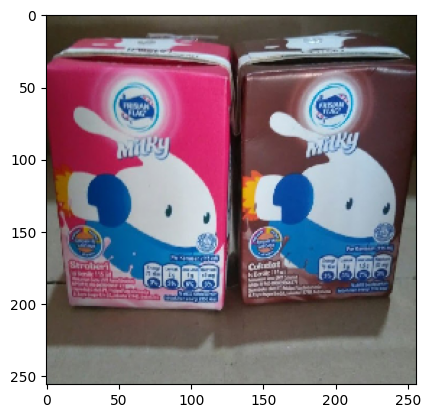

In [21]:
import requests

img_data = requests.get('https://lh6.googleusercontent.com/proxy/F-ZBe3pl0OfndrhadlTVO08-thBk3y0zEv6q90T1KhOV0a5YLsRSwvhNF-Dsgb-qzJwuKel6aJD5Ptpxj1UfbZvrN0g5mfVCiq9MlNdqyZaunE5jeAnuJEVoB8d8RB4MLAgCtCZp2vfjdooB_NMpEcLpThhNRw-GUCm3hEQgt9o7XbH6FUAONznkY1L7QwkLkrhnOuxtZPUxRYU=w1200-h630-p-k-no-nu').content 
with open('img.jpg', 'wb') as handler:
    handler.write(img_data)

path = "/content/img.jpg"

img = tf.keras.preprocessing.image.load_img(path, target_size=(256, 256))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

predictions = model.predict(img_array)

plt.imshow(img)
print(predictions[0]*100, "\n", classes)
print("Prediction: ", classes[np.argmax(predictions)], f"{predictions[0][np.argmax(predictions)]*100}%")

In [16]:
# move file txt to outside the dataset folder
file_source2 = '/content/CycleMe/CycleMeDataset/'
file_destination2 = '/content/CycleMe/'

get_files2 = os.listdir(file_source2)

shutil.move(file_source2 + 'problem_1.txt', file_destination2)

'/content/CycleMe/problem_1.txt'

In [17]:
def plot_confusion_matrix(cm, target_names, cmap=None):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}%; misclass={:0.4f}%'.format(accuracy, misclass))
    plt.show()

plt.figure(figsize=(10, 10))
true = []
predictions = []

"""
for images, labels in test_dataset.take(50):
  pred = model.predict(images)
  for i in range(32):
    try:
      ax = plt.subplot(4, 8, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      #print(classes[np.argmax(pred[i])], 100 * np.max(pred[i]), "real = " + str(classes[labels[i]]))

      true.append(labels[i])
      predictions.append(np.argmax(pred[i]))

      plt.title(classes[labels[i]])
      plt.axis("off")
    except:
      print()

"""
path = "/content/CycleMe/CycleMeDataset"
for i in os.listdir(path):
  folderPath = os.path.join(path, i)
  for j in os.listdir(folderPath)[:550]:
    fullPath = os.path.join(folderPath, j)
    try:
      img = tf.keras.preprocessing.image.load_img(fullPath, target_size=(256, 256))
      img_array = tf.keras.preprocessing.image.img_to_array(img)
      img_array = tf.expand_dims(img_array, 0) 

      preds = model.predict(img_array)
      true.append(classes.index(i))
      predictions.append(np.argmax(preds))
    except:
      print("Error on image:", fullPath)

1/1 [==============================] - 0s 41ms/step


<Figure size 1000x1000 with 0 Axes>

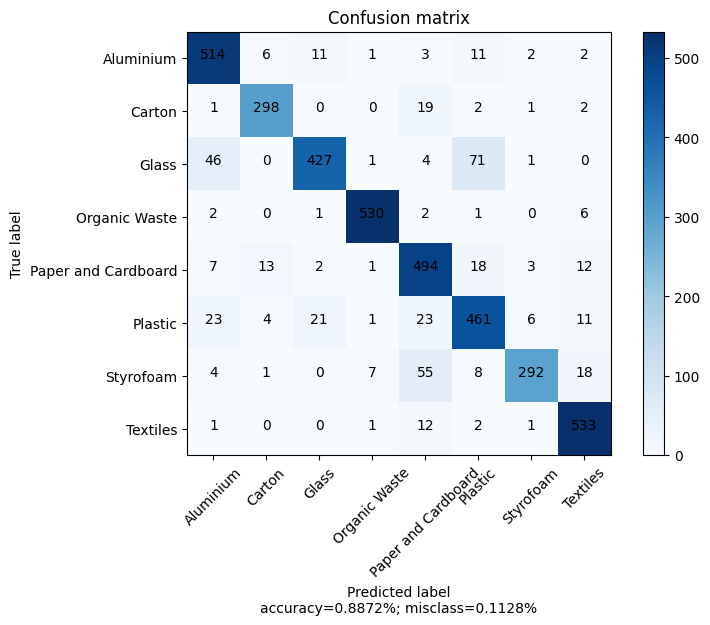

In [18]:
plot_confusion_matrix(tf.math.confusion_matrix(true, predictions), classes)